In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

from scipy.optimize import minimize
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from tqdm import tqdm_notebook

from itertools import product

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.filterwarnings('ignore')


In [2]:
def df_investigate(df):
  info = pd.DataFrame(df.count(), columns=['filled'])
  info['filled %'] = round(info['filled'] / len(df), 4)*100
  info['nunique'] = df.nunique()
  info['uniques'] = np.nan
  info['dtypes'] = df.dtypes
  for idx, row in info.iterrows():
    if row['nunique'] < 10:
      info.loc[idx, 'uniques'] = str(list(df[idx].unique()))
  return info

In [3]:
import boto3

session = boto3.Session() # Grabs session details directly from aws configuration in EC2 instance running the Notebook server
s3r = session.resource("s3")
bucket = s3r.Bucket('aida-project')
files=[]
for obj in bucket.objects.all():
  if obj.key.startswith("Covid"):
#    print(obj.key)
    if obj.key.endswith("csv"):
        files.append(obj.key)
for i,file in enumerate(files):
    print(i,"\t",file)

0 	 Covid-19/1/owid-covid-data.csv
1 	 Covid-19/2/covid-19-at.csv
2 	 Covid-19/2/covid-19-be.csv
3 	 Covid-19/2/covid-19-ch.csv
4 	 Covid-19/2/covid-19-cz.csv
5 	 Covid-19/2/covid-19-de.csv
6 	 Covid-19/2/covid-19-ecdc.csv
7 	 Covid-19/2/covid-19-england.csv
8 	 Covid-19/2/covid-19-fr.csv
9 	 Covid-19/2/covid-19-hu.csv
10 	 Covid-19/2/covid-19-ie.csv
11 	 Covid-19/2/covid-19-it.csv
12 	 Covid-19/2/covid-19-nl.csv
13 	 Covid-19/2/covid-19-no.csv
14 	 Covid-19/2/covid-19-pl.csv
15 	 Covid-19/2/covid-19-scotland.csv
16 	 Covid-19/2/covid-19-se.csv
17 	 Covid-19/2/covid-19-si.csv
18 	 Covid-19/2/covid-19-uk.csv
19 	 Covid-19/2/covid-19-wales.csv
20 	 Covid-19/3/time_series_covid19_confirmed_US.csv
21 	 Covid-19/3/time_series_covid19_confirmed_global.csv
22 	 Covid-19/3/time_series_covid19_deaths_US.csv
23 	 Covid-19/3/time_series_covid19_deaths_global.csv
24 	 Covid-19/3/time_series_covid19_recovered_global.csv
25 	 Covid-19/4/covid_jpn_metadata.csv
26 	 Covid-19/4/covid_jpn_prefecture.csv

In [4]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import numpy as np
import pandas as pd
from itertools import product
import warnings
warnings.filterwarnings('ignore')

In [5]:
file_nr = 0
selected_file = files[file_nr]

file_check = "s3://" + bucket.name + "/" + selected_file
df = pd.read_csv(file_check, error_bad_lines=False)
df.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
0,ABW,North America,Aruba,2020-03-13,2.0,2.0,NaN,NaN,0.0,NaN,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
1,ABW,North America,Aruba,2020-03-19,NaN,NaN,0.286,NaN,NaN,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN
2,ABW,North America,Aruba,2020-03-20,4.0,2.0,0.286,NaN,0.0,0.0,...,35973.781,NaN,NaN,11.62,NaN,NaN,NaN,NaN,76.29,NaN


# Data cleaning if necessary

In [6]:
# dtype: object
# iso_code and continent: nan -> other
df_1 = df.copy()
cols_na = ['iso_code', 'continent','tests_units']
replace_na = ['Other','Other','Unknown']
for i in range(len(cols_na)):
    df_1[cols_na[i]] = df_1[cols_na[i]].fillna(replace_na[i])

# total_cases = prev value, new_cases = 0, new_cases_smoothed = following value, new_deaths = 0, total_deaths = 0 (check if missing value inbetween)
# new_deaths_smoothed = following value, for remaining new_deaths_smoothed and new_cases_smoothed set previous
df_2 = df_1.copy()
df_2['total_cases'] = df_2['total_cases'].fillna(method='ffill')
df_2['new_cases'] = df_2['new_cases'].fillna(0)
df_2['new_deaths'] = df_2['new_deaths'].fillna(0)
df_2['total_deaths'] = df_2['total_deaths'].fillna(0)
df_2['new_cases_smoothed'] = df_2['new_cases_smoothed'].fillna(method='bfill')
df_2['new_deaths_smoothed'] = df_2['new_deaths_smoothed'].fillna(method='bfill')
df_2['new_cases_smoothed'] = df_2['new_cases_smoothed'].fillna(method='ffill')
df_2['new_deaths_smoothed'] = df_2['new_deaths_smoothed'].fillna(method='ffill')

df_cleaned = df_2.copy()
iso_code='ABW'
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

# Optimizing function

In [7]:
def optimize_SARIMA(parameters_list, d, exog):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - length of season
        exog - the exogenous variable
    """
    
    results = []
    
    for param in tqdm_notebook(parameters_list):
        print(param, end='')
        try: 
            model = SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], param[4], param[3], param[5])).fit(disp=-1)
        except:
            print("problem")
            break
#            continue
            
        aic = model.aic
        results.append([param, aic])
        print(aic)
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q)x(P,Q)', 'AIC']
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

# Optimize parameters

In [8]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(1, 2, 1)
d = 1
q = range(1, 2, 1)
P = range(2, 4, 1)
D = range(1, 2, 1)
Q = range(5, 7, 1)
s = range(14, 15, 1)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(1, 1, 2, 5, 1, 14), (1, 1, 2, 6, 1, 14), (1, 1, 3, 5, 1, 14), (1, 1, 3, 6, 1, 14)]
4


In [9]:
# SARIMAX(exog, order=(param[0], d, param[1]), seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)

result_df = optimize_SARIMA(parameters_list, 1, df_iso.reset_index()['new_cases'])
result_df

(1, 1, 2, 5, 1, 14)2173.605786190195
(1, 1, 2, 6, 1, 14)2175.7909018595064
(1, 1, 3, 5, 1, 14)2175.882469547754
(1, 1, 3, 6, 1, 14)2177.6335491859995



,"(p,q)x(P,Q)",AIC
0,"(1, 1, 2, 5, 1, 14)",2173.605786
1,"(1, 1, 2, 6, 1, 14)",2175.790902
2,"(1, 1, 3, 5, 1, 14)",2175.882470
3,"(1, 1, 3, 6, 1, 14)",2177.633549


# Model

In [10]:
# final parameter set for modelling and prediction
p=1
d=1
q=1
P=2
D=1
Q=5
s=14

In [11]:
model = SARIMAX(df_iso.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

In [12]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                            SARIMAX Results                                             
========================================================================================================
Dep. Variable:                                        new_cases   No. Observations:                  257
Model:             SARIMAX(1, 1, 1)x(2, 1, [1, 2, 3, 4, 5], 14)   Log Likelihood               -1076.803
Date:                                          Wed, 02 Dec 2020   AIC                           2173.606
Time:                                                  09:21:57   BIC                           2208.495
Sample:                                                       0   HQIC                          2187.660
                                                          - 257                                         
Covariance Type:                                            opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1453      0.067      2.177      0.029       0.014       0.276
ma.L1         -0.7740      0.050    -15.431      0.000      -0.872      -0.676
ar.S.L14      -0.2372      9.814     -0.024      0.981     -19.472      18.998
ar.S.L28       0.7424      6.378      0.116      0.907     -11.758      13.243
ma.S.L14      -0.5916     17.944     -0.033      0.974     -35.761      34.578
ma.S.L28      -0.9118     16.444     -0.055      0.956     -33.141      31.317
ma.S.L42       0.3102     10.073      0.031      0.975     -19.433      20.053
ma.S.L56      -0.0575      3.731     -0.015      0.988      -7.370       7.255
ma.S.L70       0.2560      5.279      0.048      0.961     -10.091      10.603
sigma2       359.3911   7951.665      0.045      0.964   -1.52e+04    1.59e+04
===================================================================================
Ljung-Box (Q):                      122.51   Jarque-Bera (JB):              1296.84
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              49.09   Skew:                             1.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        13.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

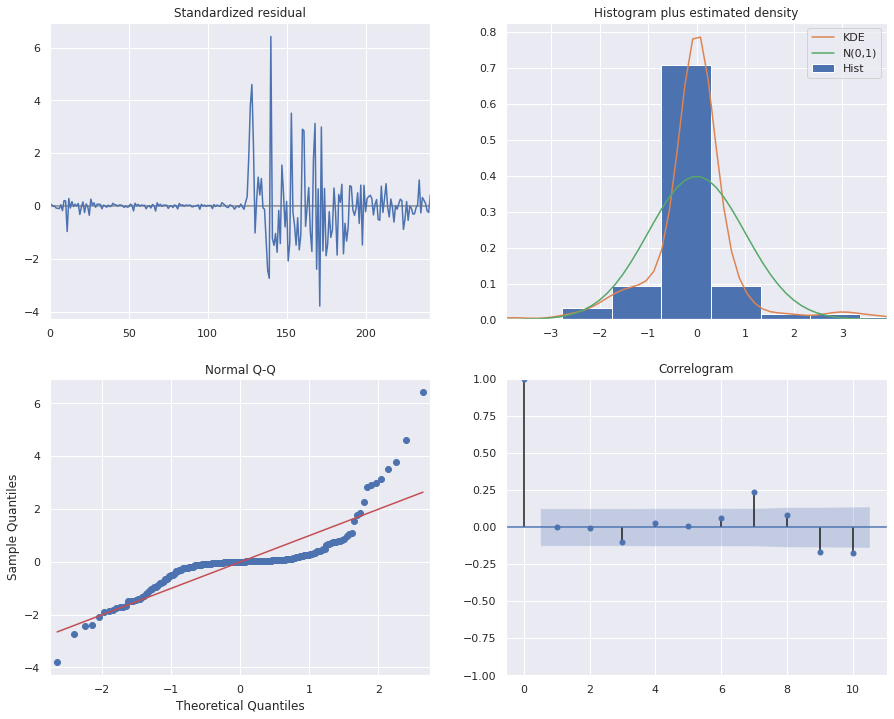

In [13]:
model.plot_diagnostics(figsize=(15,12));

In [14]:
df_tableau=df_iso.copy()
drop_cols=['total_cases','new_cases_smoothed', 'total_deaths', 'new_deaths', \
       'new_deaths_smoothed', 'total_cases_per_million', \
       'new_cases_per_million', 'new_cases_smoothed_per_million', \
       'total_deaths_per_million', 'new_deaths_per_million', \
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients', \
       'icu_patients_per_million', 'hosp_patients', \
       'hosp_patients_per_million', 'weekly_icu_admissions', \
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions', \
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests', \
       'total_tests_per_thousand', 'new_tests_per_thousand', \
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand', \
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index', \
       'population', 'population_density', 'median_age', 'aged_65_older', \
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty', \
       'cardiovasc_death_rate', 'diabetes_prevalence', 'female_smokers', \
       'male_smokers', 'handwashing_facilities', 'hospital_beds_per_thousand', \
       'life_expectancy', 'human_development_index']
df_tableau.drop(drop_cols, axis=1,inplace=True)
df_tableau

,iso_code,continent,location,date,new_cases
0,ABW,North America,Aruba,2020-03-13,2.0
1,ABW,North America,Aruba,2020-03-19,0.0
2,ABW,North America,Aruba,2020-03-20,2.0
3,ABW,North America,Aruba,2020-03-21,0.0
4,ABW,North America,Aruba,2020-03-22,0.0
...,...,...,...,...,...
252,ABW,North America,Aruba,2020-11-25,14.0
253,ABW,North America,Aruba,2020-11-26,27.0
254,ABW,North America,Aruba,2020-11-27,13.0
255,ABW,North America,Aruba,2020-11-28,17.0


In [15]:
model.fittedvalues

0       0.000000
1       1.999634
2       0.000679
3       1.999367
4       0.000640
         ...    
252     9.760133
253    25.120387
254    16.603962
255    21.763198
256    16.739349
Length: 257, dtype: float64

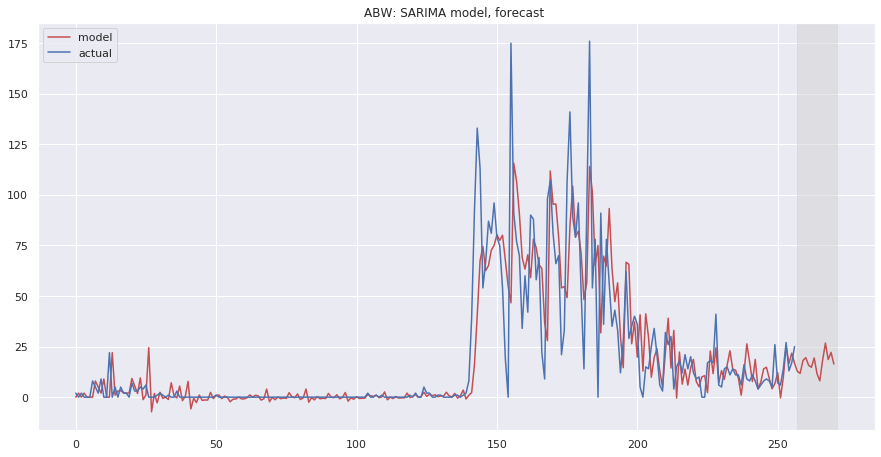

In [16]:
from datetime import timedelta

df_iso['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso.shape[0], end=df_iso.shape[0] + 13)
forecast = df_iso['arima_model'].append(forecast)
last_known_date = pd.to_datetime(df_iso.loc[df_iso.shape[0]-1,'date'])


list_t = []

for i in range(14):
    t = (last_known_date + timedelta(days=i)).strftime("%Y-%m-%d")

    list_t.append(t)


df_to_add = pd.DataFrame(list(zip(list_t, forecast)), 
               columns =['date', 'predicted']) 




df_tableau_final = df_tableau.append(df_to_add)

saveit=False
if saveit == True:
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-ar.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-ar.csv", Key='Covid-19/output/predictions-for-tableau-ar.csv')






plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso)),df_iso['new_cases'], label='actual')
plt.legend()
"""
shift_line=1
st=(y_end-y_start+1)*12
max0=max(forecast[st:st+13])+shift_line
max1=max(forecast[-13:-1])+shift_line
min0=min(forecast[st:st+13])-shift_line
min1=min(forecast[-13:-1])-shift_line
plt.plot([len(df_iso),len(forecast)],[max0,max1],c='black')
plt.plot([len(df_iso),len(forecast)],[max0,max0],c='black',linestyle='dotted')
plt.plot([len(df_iso),len(forecast)],[min0,min1],c='black')
plt.plot([len(df_iso),len(forecast)],[min0,min0],c='black',linestyle='dotted')
#plt.lines(min0,min1,c='black')
"""

plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Germany for model

In [105]:
df_2[df_2.location == 'Germany']

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
13975,DEU,Europe,Germany,2019-12-31,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
13976,DEU,Europe,Germany,2020-01-01,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
13977,DEU,Europe,Germany,2020-01-02,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
13978,DEU,Europe,Germany,2020-01-03,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
13979,DEU,Europe,Germany,2020-01-04,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14305,DEU,Europe,Germany,2020-11-25,961320.0,18633.0,18287.571,14771.0,410.0,236.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14306,DEU,Europe,Germany,2020-11-26,983588.0,22268.0,18238.857,15160.0,389.0,255.714,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14307,DEU,Europe,Germany,2020-11-27,1006394.0,22806.0,18118.571,15586.0,426.0,279.429,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14308,DEU,Europe,Germany,2020-11-28,1028089.0,21695.0,17937.286,15965.0,379.0,297.286,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936


In [106]:
df_cleaned = df_2.copy()
iso_code='DEU'
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

In [107]:
df_iso

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
13975,DEU,Europe,Germany,2019-12-31,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
13976,DEU,Europe,Germany,2020-01-01,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
13977,DEU,Europe,Germany,2020-01-02,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
13978,DEU,Europe,Germany,2020-01-03,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
13979,DEU,Europe,Germany,2020-01-04,518649.0,0.0,0.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14305,DEU,Europe,Germany,2020-11-25,961320.0,18633.0,18287.571,14771.0,410.0,236.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14306,DEU,Europe,Germany,2020-11-26,983588.0,22268.0,18238.857,15160.0,389.0,255.714,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14307,DEU,Europe,Germany,2020-11-27,1006394.0,22806.0,18118.571,15586.0,426.0,279.429,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14308,DEU,Europe,Germany,2020-11-28,1028089.0,21695.0,17937.286,15965.0,379.0,297.286,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936


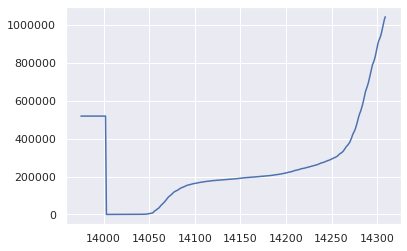

In [108]:
df_iso.total_cases.plot(kind='line')

In [109]:
start_index=df_iso[df_iso.total_cases < 2].index[0]

In [125]:
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
14003,DEU,Europe,Germany,2020-01-28,1.0,1.0,0.143,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14004,DEU,Europe,Germany,2020-01-29,4.0,3.0,0.571,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14005,DEU,Europe,Germany,2020-01-30,4.0,0.0,0.571,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14006,DEU,Europe,Germany,2020-01-31,5.0,1.0,0.714,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14007,DEU,Europe,Germany,2020-02-01,7.0,2.0,1.000,0.0,0.0,0.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14305,DEU,Europe,Germany,2020-11-25,961320.0,18633.0,18287.571,14771.0,410.0,236.000,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14306,DEU,Europe,Germany,2020-11-26,983588.0,22268.0,18238.857,15160.0,389.0,255.714,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14307,DEU,Europe,Germany,2020-11-27,1006394.0,22806.0,18118.571,15586.0,426.0,279.429,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936
14308,DEU,Europe,Germany,2020-11-28,1028089.0,21695.0,17937.286,15965.0,379.0,297.286,...,45229.245,NaN,156.139,8.31,28.2,33.1,NaN,8.0,81.33,0.936


In [23]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(6, 7, 1)
d = 1
q = range(2, 3, 1)
P = range(1, 2, 1)
D = range(2, 3, 1)
Q = range(1, 2, 1)
s = range(7, 16, 2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(6, 2, 1, 1, 2, 7), (6, 2, 1, 1, 2, 9), (6, 2, 1, 1, 2, 11), (6, 2, 1, 1, 2, 13), (6, 2, 1, 1, 2, 15)]
5


In [24]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

(6, 2, 1, 1, 2, 7)4629.138420571987
(6, 2, 1, 1, 2, 9)4930.410856341159
(6, 2, 1, 1, 2, 11)4875.552237445596
(6, 2, 1, 1, 2, 13)4834.854869535923
(6, 2, 1, 1, 2, 15)4785.514440272427



,"(p,q)x(P,Q)",AIC
0,"(6, 2, 1, 1, 2, 7)",4629.138421
1,"(6, 2, 1, 1, 2, 15)",4785.514440
2,"(6, 2, 1, 1, 2, 13)",4834.854870
3,"(6, 2, 1, 1, 2, 11)",4875.552237
4,"(6, 2, 1, 1, 2, 9)",4930.410856


In [111]:
# final parameter set for modelling and prediction
p=6
d=1
q=2
P=1
D=2
Q=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  307
Model:             SARIMAX(6, 1, 2)x(1, 2, [1], 7)   Log Likelihood               -2303.569
Date:                             Wed, 02 Dec 2020   AIC                           4629.138
Time:                                     12:55:53   BIC                           4669.583
Sample:                                          0   HQIC                          4645.339
                                             - 307                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -2.0091      0.077    -26.021      0.000      -2.160      -1.858
ar.L2         -1.7616      0.149    -11.812      0.000      -2.054      -1.469
ar.L3         -0.9240      0.166     -5.553      0.000      -1.250      -0.598
ar.L4         -0.4794      0.157     -3.056      0.002      -0.787      -0.172
ar.L5         -0.2477      0.129     -1.926      0.054      -0.500       0.004
ar.L6          0.0198      0.064      0.309      0.757      -0.106       0.146
ma.L1          1.6736      0.054     31.225      0.000       1.569       1.779
ma.L2          0.9274      0.049     19.043      0.000       0.832       1.023
ar.S.L7        0.0782      0.048      1.632      0.103      -0.016       0.172
ma.S.L7       -0.9892      0.122     -8.096      0.000      -1.229      -0.750
sigma2      3.927e+05   4.06e+04      9.665      0.000    3.13e+05    4.72e+05
===================================================================================
Ljung-Box (Q):                       62.20   Jarque-Bera (JB):              1799.99
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               1.23   Skew:                             0.21
Prob(H) (two-sided):                  0.31   Kurtosis:                        15.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

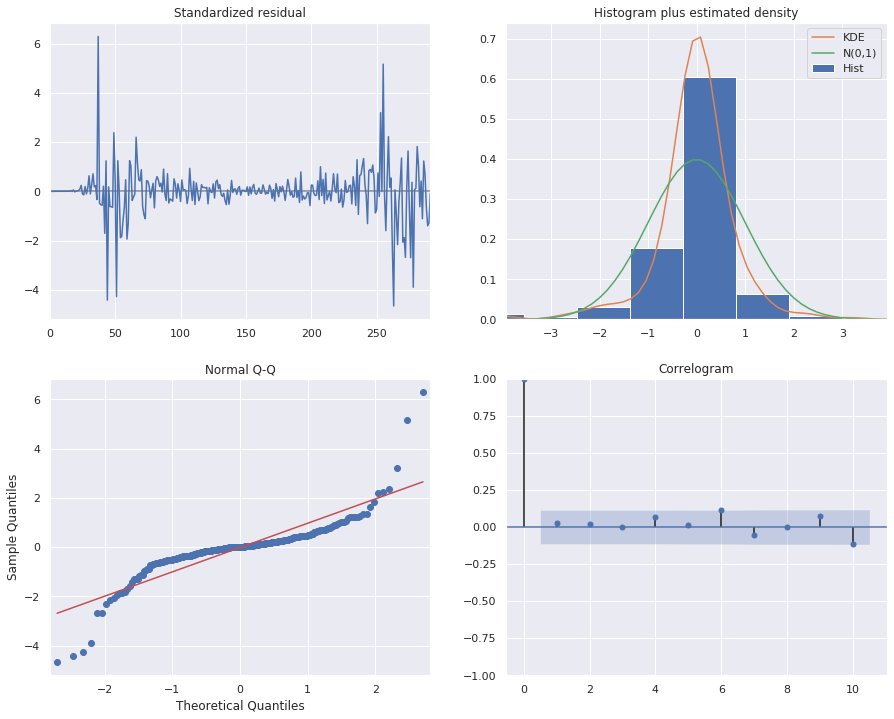

In [112]:
model.plot_diagnostics(figsize=(15,12));

In [126]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)
df_tableau

,iso_code,continent,location,date,new_cases
0,DEU,Europe,Germany,2020-01-28,1.0
1,DEU,Europe,Germany,2020-01-29,3.0
2,DEU,Europe,Germany,2020-01-30,0.0
3,DEU,Europe,Germany,2020-01-31,1.0
4,DEU,Europe,Germany,2020-02-01,2.0
...,...,...,...,...,...
302,DEU,Europe,Germany,2020-11-25,18633.0
303,DEU,Europe,Germany,2020-11-26,22268.0
304,DEU,Europe,Germany,2020-11-27,22806.0
305,DEU,Europe,Germany,2020-11-28,21695.0


2020-11-29
Europe
   iso_code continent location        date     predicted
0       DEU    Europe  Germany  2020-11-30   9528.182443
1       DEU    Europe  Germany  2020-12-01  12860.502541
2       DEU    Europe  Germany  2020-12-02  17127.370780
3       DEU    Europe  Germany  2020-12-03  21816.222896
4       DEU    Europe  Germany  2020-12-04  21415.490428
5       DEU    Europe  Germany  2020-12-05  20899.021035
6       DEU    Europe  Germany  2020-12-06  13304.580904
7       DEU    Europe  Germany  2020-12-07   8275.496683
8       DEU    Europe  Germany  2020-12-08  11551.519620
9       DEU    Europe  Germany  2020-12-09  16158.490410
10      DEU    Europe  Germany  2020-12-10  20549.116972
11      DEU    Europe  Germany  2020-12-11  20667.590966
12      DEU    Europe  Germany  2020-12-12  19570.749554
13      DEU    Europe  Germany  2020-12-13  12289.916089
   iso_code continent location        date  new_cases     predicted
0       DEU    Europe  Germany  2020-01-28        1.0      

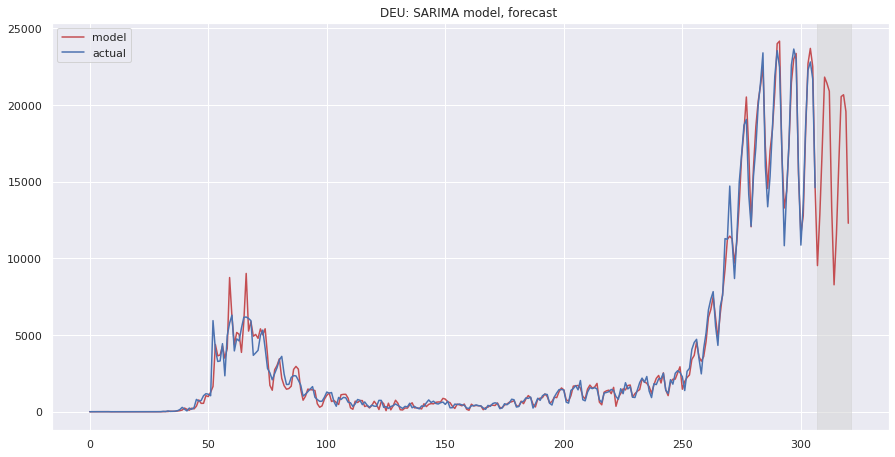

In [144]:
df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-de.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-de.csv", Key='Covid-19/output/predictions-for-tableau-de.csv')






plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()
"""
shift_line=1
st=(y_end-y_start+1)*12
max0=max(forecast[st:st+13])+shift_line
max1=max(forecast[-13:-1])+shift_line
min0=min(forecast[st:st+13])-shift_line
min1=min(forecast[-13:-1])-shift_line
plt.plot([len(df_iso),len(forecast)],[max0,max1],c='black')
plt.plot([len(df_iso),len(forecast)],[max0,max0],c='black',linestyle='dotted')
plt.plot([len(df_iso),len(forecast)],[min0,min1],c='black')
plt.plot([len(df_iso),len(forecast)],[min0,min0],c='black',linestyle='dotted')
#plt.lines(min0,min1,c='black')
"""

plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# USA

In [145]:
df_2[df_2.location == 'United States']

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
55729,USA,North America,United States,2019-12-31,5511.0,0.0,0.000,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55730,USA,North America,United States,2020-01-01,5511.0,0.0,0.000,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55731,USA,North America,United States,2020-01-02,5511.0,0.0,0.000,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55732,USA,North America,United States,2020-01-03,5511.0,0.0,0.000,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55733,USA,North America,United States,2020-01-04,5511.0,0.0,0.000,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56059,USA,North America,United States,2020-11-25,12591165.0,170293.0,175909.000,259925.0,2224.0,1605.429,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
56060,USA,North America,United States,2020-11-26,12777754.0,186589.0,178278.143,262266.0,2341.0,1675.571,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
56061,USA,North America,United States,2020-11-27,12883845.0,106091.0,166574.000,263455.0,1189.0,1557.143,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
56062,USA,North America,United States,2020-11-28,13091758.0,207913.0,168259.143,264859.0,1404.0,1492.286,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924


In [146]:
df_cleaned = df_2.copy()
iso_code='USA'
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

In [147]:
df_iso.head(40)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
55729,USA,North America,United States,2019-12-31,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55730,USA,North America,United States,2020-01-01,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55731,USA,North America,United States,2020-01-02,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55732,USA,North America,United States,2020-01-03,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55733,USA,North America,United States,2020-01-04,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55734,USA,North America,United States,2020-01-05,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55735,USA,North America,United States,2020-01-06,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55736,USA,North America,United States,2020-01-07,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55737,USA,North America,United States,2020-01-08,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55738,USA,North America,United States,2020-01-09,5511.0,0.0,0.000,0.0,0.0,0.0,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924


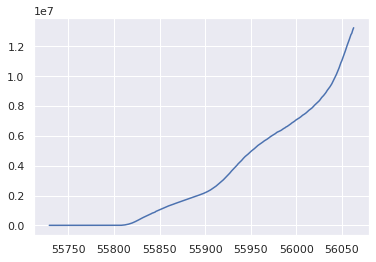

In [148]:
df_iso.total_cases.plot(kind='line')

In [149]:
start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
55750,USA,North America,United States,2020-01-21,1.0,1.0,0.143,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55751,USA,North America,United States,2020-01-22,1.0,0.0,0.143,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55752,USA,North America,United States,2020-01-23,1.0,0.0,0.143,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55753,USA,North America,United States,2020-01-24,1.0,0.0,0.143,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
55754,USA,North America,United States,2020-01-25,2.0,1.0,0.286,0.0,0.0,0.000,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56059,USA,North America,United States,2020-11-25,12591165.0,170293.0,175909.000,259925.0,2224.0,1605.429,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
56060,USA,North America,United States,2020-11-26,12777754.0,186589.0,178278.143,262266.0,2341.0,1675.571,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
56061,USA,North America,United States,2020-11-27,12883845.0,106091.0,166574.000,263455.0,1189.0,1557.143,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924
56062,USA,North America,United States,2020-11-28,13091758.0,207913.0,168259.143,264859.0,1404.0,1492.286,...,54225.446,1.2,151.089,10.79,19.1,24.6,NaN,2.77,78.86,0.924


In [54]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(0, 1, 1)
d = 1
q = range(2, 3, 1)
P = range(1, 2, 1)
D = range(3, 5, 1)
Q = range(1, 2, 1)
s = range(24, 25, 2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(0, 2, 1, 1, 3, 24), (0, 2, 1, 1, 4, 24)]
2


In [55]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

(0, 2, 1, 1, 3, 24)5563.458951940638
(0, 2, 1, 1, 4, 24)5470.522674915369



,"(p,q)x(P,Q)",AIC
0,"(0, 2, 1, 1, 4, 24)",5470.522675
1,"(0, 2, 1, 1, 3, 24)",5563.458952


In [150]:
# final parameter set for modelling and prediction
p=0
d=1
q=2
P=1
D=4
Q=1
s=24

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            new_cases   No. Observations:                  314
Model:             SARIMAX(0, 1, 2)x(1, 4, [1], 24)   Log Likelihood               -2730.261
Date:                              Wed, 02 Dec 2020   AIC                           5470.523
Time:                                      13:34:47   BIC                           5487.422
Sample:                                           0   HQIC                          5477.349
                                              - 314                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6649      1.218     -0.546      0.585      -3.051       1.721
ma.L2          0.0190      1.578      0.012      0.990      -3.075       3.113
ar.S.L24      -0.9998      0.613     -1.630      0.103      -2.202       0.203
ma.S.L24      -0.6657      1.556     -0.428      0.669      -3.715       2.383
sigma2      3.697e+09   1.58e-09   2.34e+18      0.000     3.7e+09     3.7e+09
===================================================================================
Ljung-Box (Q):                      293.62   Jarque-Bera (JB):                 2.47
Prob(Q):                              0.00   Prob(JB):                         0.29
Heteroskedasticity (H):               0.32   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.46e+33. Standard errors may be unstable.
"""

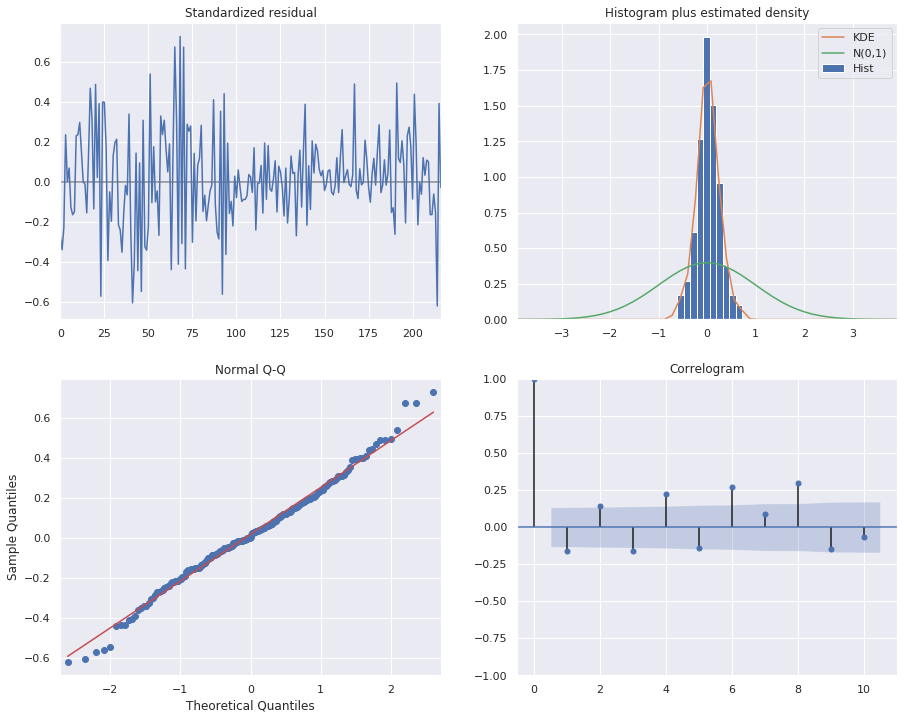

In [151]:
model.plot_diagnostics(figsize=(15,12));

In [152]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)
df_tableau

,iso_code,continent,location,date,new_cases
0,USA,North America,United States,2020-01-21,1.0
1,USA,North America,United States,2020-01-22,0.0
2,USA,North America,United States,2020-01-23,0.0
3,USA,North America,United States,2020-01-24,0.0
4,USA,North America,United States,2020-01-25,1.0
...,...,...,...,...,...
309,USA,North America,United States,2020-11-25,170293.0
310,USA,North America,United States,2020-11-26,186589.0
311,USA,North America,United States,2020-11-27,106091.0
312,USA,North America,United States,2020-11-28,207913.0


2020-11-29
North America
   iso_code      continent       location        date      predicted
0       USA  North America  United States  2020-11-30  185626.272333
1       USA  North America  United States  2020-12-01  209986.256651
2       USA  North America  United States  2020-12-02  198310.277222
3       USA  North America  United States  2020-12-03  204500.490541
4       USA  North America  United States  2020-12-04  234759.753378
5       USA  North America  United States  2020-12-05  212952.455300
6       USA  North America  United States  2020-12-06  183045.744292
7       USA  North America  United States  2020-12-07  228418.473787
8       USA  North America  United States  2020-12-08  216354.515591
9       USA  North America  United States  2020-12-09  215120.814361
10      USA  North America  United States  2020-12-10  224653.307433
11      USA  North America  United States  2020-12-11  259071.973366
12      USA  North America  United States  2020-12-12  257817.245556
13      U

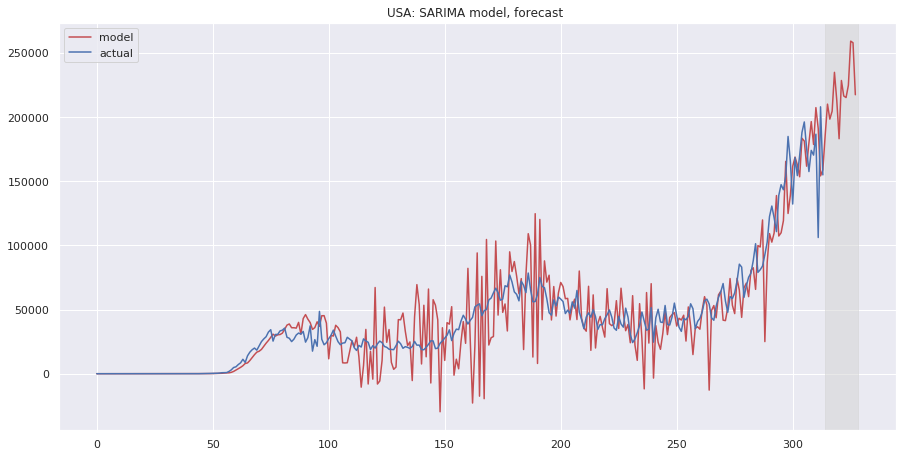

In [153]:
df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-us.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-us.csv", Key='Covid-19/output/predictions-for-tableau-us.csv')






plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()
"""
shift_line=1
st=(y_end-y_start+1)*12
max0=max(forecast[st:st+13])+shift_line
max1=max(forecast[-13:-1])+shift_line
min0=min(forecast[st:st+13])-shift_line
min1=min(forecast[-13:-1])-shift_line
plt.plot([len(df_iso),len(forecast)],[max0,max1],c='black')
plt.plot([len(df_iso),len(forecast)],[max0,max0],c='black',linestyle='dotted')
plt.plot([len(df_iso),len(forecast)],[min0,min1],c='black')
plt.plot([len(df_iso),len(forecast)],[min0,min0],c='black',linestyle='dotted')
#plt.lines(min0,min1,c='black')
"""

plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Sweden


In [154]:
df_2[df_2.location == 'Sweden']

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
50618,SWE,Europe,Sweden,2019-12-31,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50619,SWE,Europe,Sweden,2020-01-01,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50620,SWE,Europe,Sweden,2020-01-02,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50621,SWE,Europe,Sweden,2020-01-03,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50622,SWE,Europe,Sweden,2020-01-04,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50946,SWE,Europe,Sweden,2020-11-23,222047.0,2423.0,4567.857,6631.0,33.0,30.429,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50947,SWE,Europe,Sweden,2020-11-24,225925.0,3878.0,4758.429,6652.0,21.0,28.857,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50948,SWE,Europe,Sweden,2020-11-25,231599.0,5674.0,4931.857,6662.0,10.0,24.714,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50949,SWE,Europe,Sweden,2020-11-26,237665.0,6066.0,5089.571,6665.0,3.0,21.429,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933


In [155]:
df_cleaned = df_2.copy()
iso_code='SWE'
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]
df_iso

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
50618,SWE,Europe,Sweden,2019-12-31,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50619,SWE,Europe,Sweden,2020-01-01,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50620,SWE,Europe,Sweden,2020-01-02,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50621,SWE,Europe,Sweden,2020-01-03,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50622,SWE,Europe,Sweden,2020-01-04,74264.0,0.0,0.000,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50946,SWE,Europe,Sweden,2020-11-23,222047.0,2423.0,4567.857,6631.0,33.0,30.429,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50947,SWE,Europe,Sweden,2020-11-24,225925.0,3878.0,4758.429,6652.0,21.0,28.857,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50948,SWE,Europe,Sweden,2020-11-25,231599.0,5674.0,4931.857,6662.0,10.0,24.714,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50949,SWE,Europe,Sweden,2020-11-26,237665.0,6066.0,5089.571,6665.0,3.0,21.429,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933


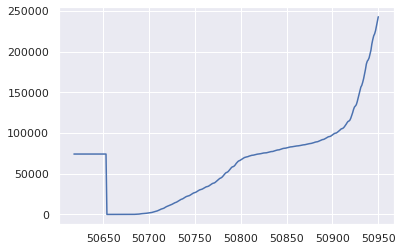

In [156]:
df_iso.total_cases.plot(kind='line')

In [157]:
start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
50654,SWE,Europe,Sweden,2020-02-05,1.0,1.0,0.143,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50655,SWE,Europe,Sweden,2020-02-06,1.0,0.0,0.143,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50656,SWE,Europe,Sweden,2020-02-07,1.0,0.0,0.143,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50657,SWE,Europe,Sweden,2020-02-08,1.0,0.0,0.143,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50658,SWE,Europe,Sweden,2020-02-09,1.0,0.0,0.143,0.0,0.0,0.000,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50946,SWE,Europe,Sweden,2020-11-23,222047.0,2423.0,4567.857,6631.0,33.0,30.429,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50947,SWE,Europe,Sweden,2020-11-24,225925.0,3878.0,4758.429,6652.0,21.0,28.857,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50948,SWE,Europe,Sweden,2020-11-25,231599.0,5674.0,4931.857,6662.0,10.0,24.714,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933
50949,SWE,Europe,Sweden,2020-11-26,237665.0,6066.0,5089.571,6665.0,3.0,21.429,...,46949.283,0.5,133.982,4.79,18.8,18.9,NaN,2.22,82.8,0.933


In [81]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(5, 6, 1)
d = 1
q = range(3, 4, 1)
P = range(1, 2, 1)
D = range(2, 3, 1)
Q = range(0, 1, 1)
s = range(17, 26, 2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print(len(parameters_list))

[(5, 3, 1, 0, 2, 17), (5, 3, 1, 0, 2, 19), (5, 3, 1, 0, 2, 21), (5, 3, 1, 0, 2, 23), (5, 3, 1, 0, 2, 25)]
5


In [82]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

(5, 3, 1, 0, 2, 17)3920.133933320501
(5, 3, 1, 0, 2, 19)3859.95526523877
(5, 3, 1, 0, 2, 21)4435.504820726211
(5, 3, 1, 0, 2, 23)3749.265618616654
(5, 3, 1, 0, 2, 25)3679.0468752498455



,"(p,q)x(P,Q)",AIC
0,"(5, 3, 1, 0, 2, 25)",3679.046875
1,"(5, 3, 1, 0, 2, 23)",3749.265619
2,"(5, 3, 1, 0, 2, 19)",3859.955265
3,"(5, 3, 1, 0, 2, 17)",3920.133933
4,"(5, 3, 1, 0, 2, 21)",4435.504821


In [158]:
# final parameter set for modelling and prediction
p=5
d=1
q=3
P=1
D=2
Q=0
s=25

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  297
Model:             SARIMAX(5, 1, 3)x(1, 2, [], 25)   Log Likelihood               -1829.523
Date:                             Wed, 02 Dec 2020   AIC                           3679.047
Time:                                     13:40:16   BIC                           3714.100
Sample:                                          0   HQIC                          3693.161
                                             - 297                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1109      0.060     -1.846      0.065      -0.229       0.007
ar.L2         -0.6874      0.050    -13.793      0.000      -0.785      -0.590
ar.L3         -0.4567      0.041    -11.245      0.000      -0.536      -0.377
ar.L4         -0.3614      0.034    -10.750      0.000      -0.427      -0.295
ar.L5         -0.7845      0.053    -14.855      0.000      -0.888      -0.681
ma.L1         -0.1856      0.089     -2.077      0.038      -0.361      -0.010
ma.L2          0.5819      0.053     10.948      0.000       0.478       0.686
ma.L3         -0.1218      0.089     -1.371      0.170      -0.296       0.052
ar.S.L25      -0.6789      0.118     -5.761      0.000      -0.910      -0.448
sigma2      2.018e+05   1.46e+04     13.851      0.000    1.73e+05     2.3e+05
===================================================================================
Ljung-Box (Q):                       90.89   Jarque-Bera (JB):               710.41
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):              10.41   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

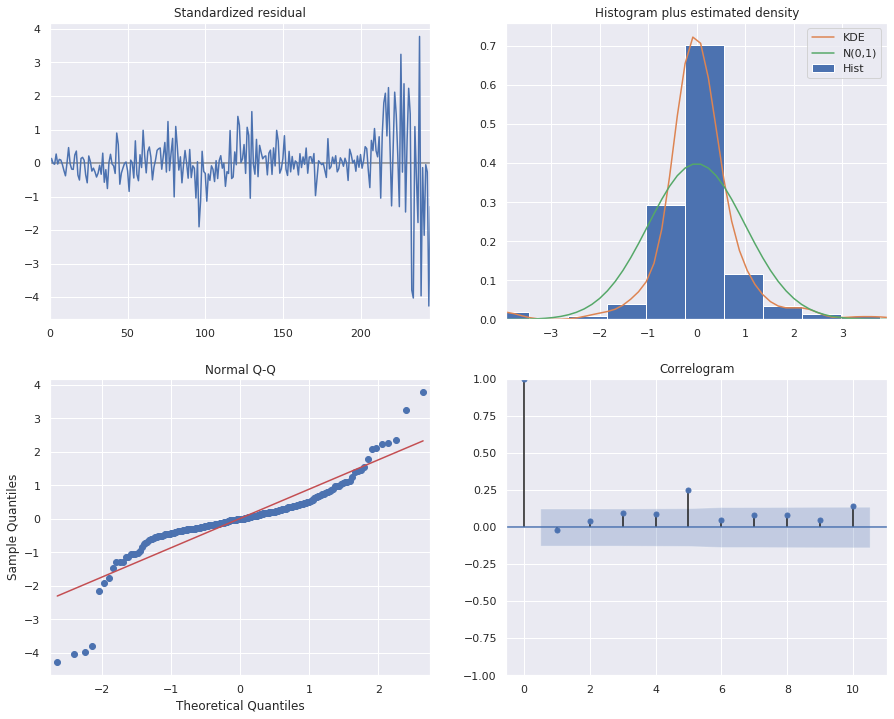

In [159]:
model.plot_diagnostics(figsize=(15,12));

In [160]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)
df_tableau

,iso_code,continent,location,date,new_cases
0,SWE,Europe,Sweden,2020-02-05,1.0
1,SWE,Europe,Sweden,2020-02-06,0.0
2,SWE,Europe,Sweden,2020-02-07,0.0
3,SWE,Europe,Sweden,2020-02-08,0.0
4,SWE,Europe,Sweden,2020-02-09,0.0
...,...,...,...,...,...
292,SWE,Europe,Sweden,2020-11-23,2423.0
293,SWE,Europe,Sweden,2020-11-24,3878.0
294,SWE,Europe,Sweden,2020-11-25,5674.0
295,SWE,Europe,Sweden,2020-11-26,6066.0


2020-11-27
Europe
   iso_code continent location        date    predicted
0       SWE    Europe   Sweden  2020-11-28  5178.548478
1       SWE    Europe   Sweden  2020-11-29  4286.186228
2       SWE    Europe   Sweden  2020-11-30  4430.634673
3       SWE    Europe   Sweden  2020-12-01  5565.457997
4       SWE    Europe   Sweden  2020-12-02  6432.773858
5       SWE    Europe   Sweden  2020-12-03  7944.550046
6       SWE    Europe   Sweden  2020-12-04  6647.897157
7       SWE    Europe   Sweden  2020-12-05  7520.563940
8       SWE    Europe   Sweden  2020-12-06  5735.862374
9       SWE    Europe   Sweden  2020-12-07  6114.070909
10      SWE    Europe   Sweden  2020-12-08  6627.162876
11      SWE    Europe   Sweden  2020-12-09  9324.346995
12      SWE    Europe   Sweden  2020-12-10  6968.041487
13      SWE    Europe   Sweden  2020-12-11  5973.114105
   iso_code continent location        date  new_cases    predicted
0       SWE    Europe   Sweden  2020-02-05        1.0     0.000000
1       

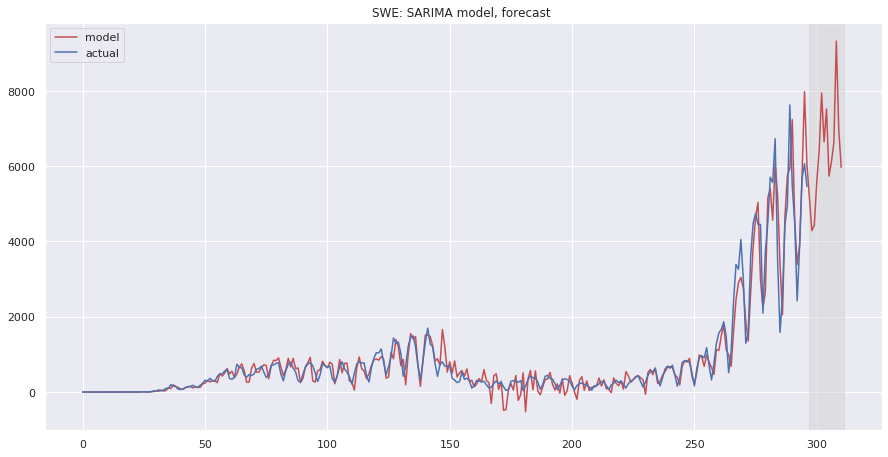

In [161]:
df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-se.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-se.csv", Key='Covid-19/output/predictions-for-tableau-se.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()
"""
shift_line=1
st=(y_end-y_start+1)*12
max0=max(forecast[st:st+13])+shift_line
max1=max(forecast[-13:-1])+shift_line
min0=min(forecast[st:st+13])-shift_line
min1=min(forecast[-13:-1])-shift_line
plt.plot([len(df_iso),len(forecast)],[max0,max1],c='black')
plt.plot([len(df_iso),len(forecast)],[max0,max0],c='black',linestyle='dotted')
plt.plot([len(df_iso),len(forecast)],[min0,min1],c='black')
plt.plot([len(df_iso),len(forecast)],[min0,min0],c='black',linestyle='dotted')
#plt.lines(min0,min1,c='black')
"""

plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Find Top 10 countries with cases

In [168]:
df_2.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
     

In [197]:
# highest total_cases for latest available common date
ntop=12
top_list=[]
tmp = df_2[df_2.date == '2020-11-25'].groupby('location')['total_cases'].nlargest(1).sort_values(ascending=False).index[:ntop]
for i in range(ntop):
    top_list.append(df_2.loc[tmp[i],'location'])
top_list

['World',
 'United States',
 'India',
 'Brazil',
 'Russia',
 'France',
 'Spain',
 'United Kingdom',
 'Italy',
 'Argentina',
 'Colombia',
 'Mexico']

In [202]:
# do not use 'World' and countries already predicted (by now: 'Germany','United States','Sweden')
remove_countries = ['World','Germany','United States','Sweden']

for country in remove_countries:
    try:
        top_list.remove(country)
    except:
        continue
print(top_list)

['India', 'Brazil', 'Russia', 'France', 'Spain', 'United Kingdom', 'Italy', 'Argentina', 'Colombia', 'Mexico']


# India

In [221]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'India'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
25562,IND,Asia,India,2020-01-30,1.0,1.0,0.143,0.0,0.0,0.0,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.64
25563,IND,Asia,India,2020-01-31,1.0,0.0,0.143,0.0,0.0,0.0,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.64
25564,IND,Asia,India,2020-02-01,1.0,0.0,0.143,0.0,0.0,0.0,...,6426.674,21.2,282.28,10.39,1.9,20.6,59.55,0.53,69.66,0.64


In [243]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(2, 3, 1)
d = 1
q = range(2, 3, 1)
P = range(2, 3, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(7,8,2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

[(2, 2, 2, 1, 1, 7)]
runs:  1


In [244]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

(2, 2, 2, 1, 1, 7)5365.1706793062



,"(p,q)x(P,Q)",AIC
0,"(2, 2, 2, 1, 1, 7)",5365.170679


In [245]:
# final parameter set for modelling and prediction
p=2
d=1
q=2
P=2
Q=1
D=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                           new_cases   No. Observations:                  305
Model:             SARIMAX(2, 1, 2)x(2, 1, [1], 7)   Log Likelihood               -2674.585
Date:                             Wed, 02 Dec 2020   AIC                           5365.171
Time:                                     22:05:57   BIC                           5394.721
Sample:                                          0   HQIC                          5377.001
                                             - 305                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1801      0.017    -10.353      0.000      -0.214      -0.146
ar.L2         -0.9718      0.016    -59.901      0.000      -1.004      -0.940
ma.L1          0.0966      0.022      4.353      0.000       0.053       0.140
ma.L2          0.9533      0.018     54.360      0.000       0.919       0.988
ar.S.L7       -0.4294      0.087     -4.960      0.000      -0.599      -0.260
ar.S.L14      -0.3689      0.079     -4.700      0.000      -0.523      -0.215
ma.S.L7       -0.2564      0.095     -2.705      0.007      -0.442      -0.071
sigma2      3.889e+06   2.06e+05     18.862      0.000    3.48e+06    4.29e+06
===================================================================================
Ljung-Box (Q):                       61.91   Jarque-Bera (JB):               180.80
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):             104.31   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

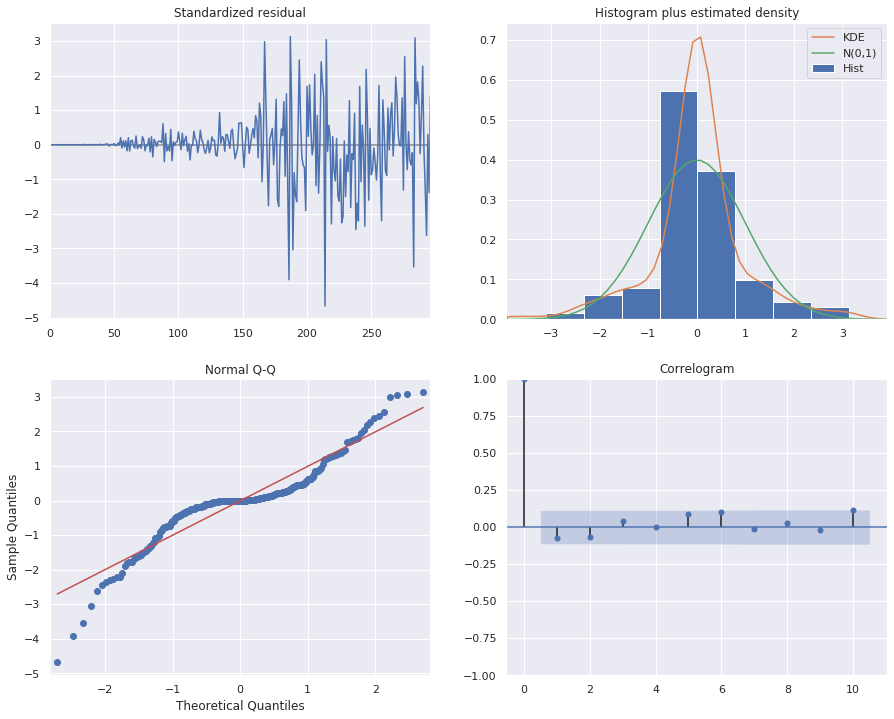

In [246]:
model.plot_diagnostics(figsize=(15,12));

2020-11-29
Asia
   iso_code continent location        date     predicted
0       IND      Asia    India  2020-11-30  39523.940739
1       IND      Asia    India  2020-12-01  32563.714790
2       IND      Asia    India  2020-12-02  39787.035548
3       IND      Asia    India  2020-12-03  43441.666714
4       IND      Asia    India  2020-12-04  41127.732380
5       IND      Asia    India  2020-12-05  40315.979452
6       IND      Asia    India  2020-12-06  38775.360361
7       IND      Asia    India  2020-12-07  33948.700186
8       IND      Asia    India  2020-12-08  28757.981388
9       IND      Asia    India  2020-12-09  36387.939122
10      IND      Asia    India  2020-12-10  41444.372882
11      IND      Asia    India  2020-12-11  40436.698889
12      IND      Asia    India  2020-12-12  39559.322000
13      IND      Asia    India  2020-12-13  38134.141707
   iso_code continent location        date  new_cases     predicted
0       IND      Asia    India  2020-01-30        1.0      0.

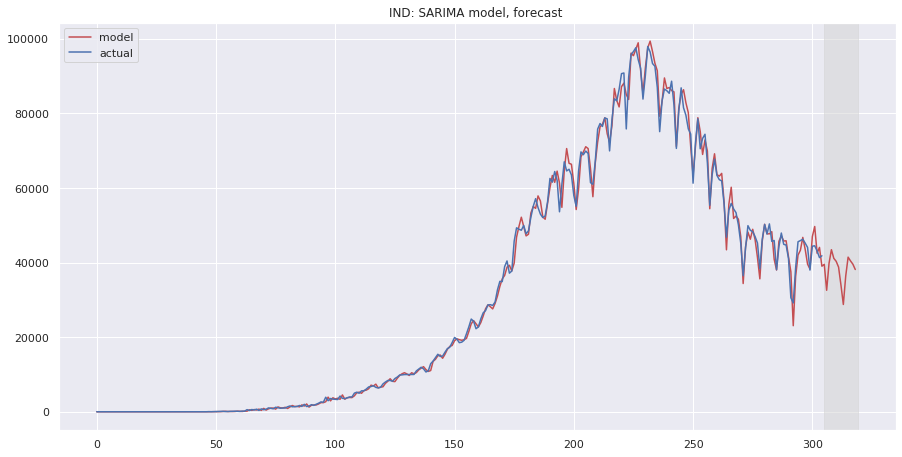

In [248]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-in.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-in.csv", Key='Covid-19/output/predictions-for-tableau-in.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Brazil

In [250]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'Brazil'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
7718,BRA,South America,Brazil,2020-02-26,1.0,1.0,0.143,0.0,0.0,0.0,...,14103.452,3.4,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.759
7719,BRA,South America,Brazil,2020-02-27,1.0,0.0,0.143,0.0,0.0,0.0,...,14103.452,3.4,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.759
7720,BRA,South America,Brazil,2020-02-28,1.0,0.0,0.143,0.0,0.0,0.0,...,14103.452,3.4,177.961,8.11,10.1,17.9,NaN,2.2,75.88,0.759


In [263]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(4, 5, 1)
d = 1
q = range(3, 4, 1)
P = range(4, 5, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(20,24,1)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

[(4, 3, 4, 1, 1, 20), (4, 3, 4, 1, 1, 21), (4, 3, 4, 1, 1, 22), (4, 3, 4, 1, 1, 23)]
runs:  4


In [264]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

(4, 3, 4, 1, 1, 20)5349.372009002596
(4, 3, 4, 1, 1, 21)5274.612504060586
(4, 3, 4, 1, 1, 22)5308.504839914553
(4, 3, 4, 1, 1, 23)5364.402842695502



,"(p,q)x(P,Q)",AIC
0,"(4, 3, 4, 1, 1, 21)",5274.612504
1,"(4, 3, 4, 1, 1, 22)",5308.504840
2,"(4, 3, 4, 1, 1, 20)",5349.372009
3,"(4, 3, 4, 1, 1, 23)",5364.402843


In [265]:
# final parameter set for modelling and prediction
p=4
d=1
q=3
P=4
Q=1
D=1
s=21

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                            new_cases   No. Observations:                  278
Model:             SARIMAX(4, 1, 3)x(4, 1, [1], 21)   Log Likelihood               -2624.306
Date:                              Wed, 02 Dec 2020   AIC                           5274.613
Time:                                      23:02:05   BIC                           5320.700
Sample:                                           0   HQIC                          5293.149
                                              - 278                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0289      0.182     -0.159      0.874      -0.385       0.328
ar.L2          0.2711      0.163      1.660      0.097      -0.049       0.591
ar.L3         -0.4984      0.112     -4.465      0.000      -0.717      -0.280
ar.L4         -0.2581      0.109     -2.369      0.018      -0.472      -0.045
ma.L1         -0.4918      0.174     -2.826      0.005      -0.833      -0.151
ma.L2         -0.5064      0.202     -2.502      0.012      -0.903      -0.110
ma.L3          0.5985      0.137      4.368      0.000       0.330       0.867
ar.S.L21      -0.3732      0.524     -0.712      0.476      -1.400       0.654
ar.S.L42      -0.1898      0.321     -0.592      0.554      -0.818       0.439
ar.S.L63      -0.2257      0.184     -1.229      0.219      -0.586       0.134
ar.S.L84      -0.1690      0.166     -1.017      0.309      -0.495       0.157
ma.S.L21      -0.2433      0.548     -0.444      0.657      -1.318       0.831
sigma2      6.105e+07   2.91e-08    2.1e+15      0.000    6.11e+07    6.11e+07
===================================================================================
Ljung-Box (Q):                       96.81   Jarque-Bera (JB):               108.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.48   Skew:                             0.76
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.16e+30. Standard errors may be unstable.
"""

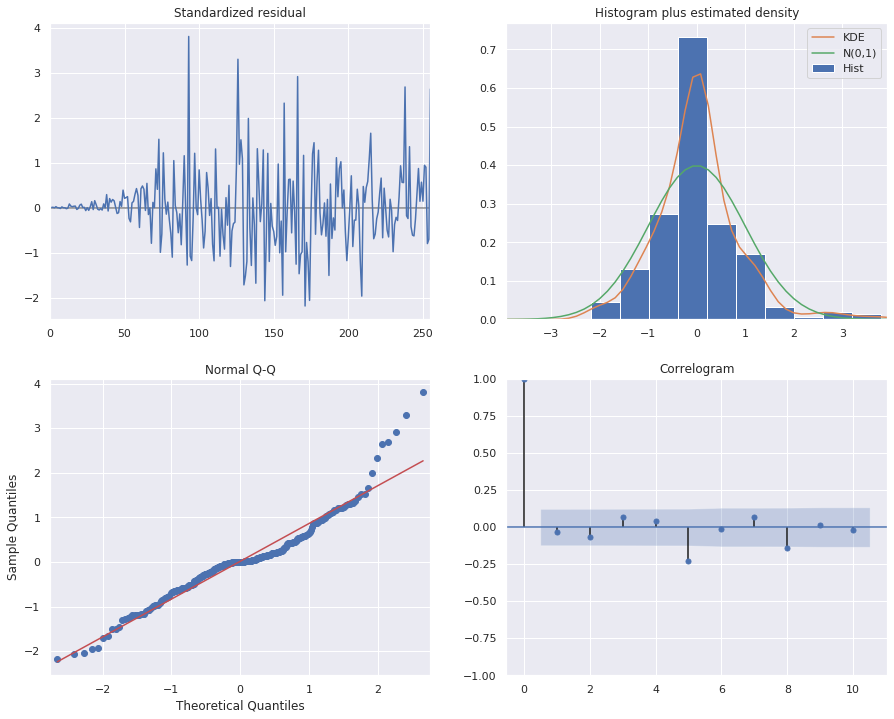

In [266]:
model.plot_diagnostics(figsize=(15,12));

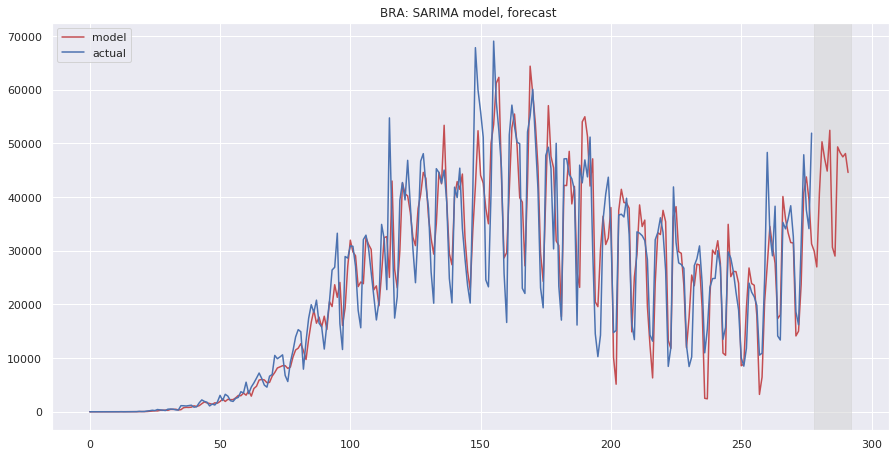

In [267]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-br.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-br.csv", Key='Covid-19/output/predictions-for-tableau-br.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Russia

In [271]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'Russia'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]
#print(df_iso)

start_index=df_iso[df_iso.total_cases < 3].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)


,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy,human_development_index
46223,RUS,Europe,Russia,2020-02-01,2.0,2.0,0.286,0.0,0.0,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.816
46224,RUS,Europe,Russia,2020-02-02,2.0,0.0,0.286,0.0,0.0,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.816
46225,RUS,Europe,Russia,2020-02-03,2.0,0.0,0.286,0.0,0.0,0.0,...,24765.954,0.1,431.297,6.18,23.4,58.3,NaN,8.05,72.58,0.816


In [282]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(1, 2, 1)
d = 1
q = range(1, 2, 1)
P = range(1, 2, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(36,50,1)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

[(1, 1, 1, 1, 1, 36), (1, 1, 1, 1, 1, 37), (1, 1, 1, 1, 1, 38), (1, 1, 1, 1, 1, 39), (1, 1, 1, 1, 1, 40), (1, 1, 1, 1, 1, 41), (1, 1, 1, 1, 1, 42), (1, 1, 1, 1, 1, 43), (1, 1, 1, 1, 1, 44), (1, 1, 1, 1, 1, 45), (1, 1, 1, 1, 1, 46), (1, 1, 1, 1, 1, 47), (1, 1, 1, 1, 1, 48), (1, 1, 1, 1, 1, 49)]
runs:  14


In [ ]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

(1, 1, 1, 1, 1, 36)4710.10381353145
(1, 1, 1, 1, 1, 37)4699.917012005254
(1, 1, 1, 1, 1, 38)4688.838756779094
(1, 1, 1, 1, 1, 39)4673.917257237509
(1, 1, 1, 1, 1, 40)4655.916947002321
(1, 1, 1, 1, 1, 41)4625.11818457037
(1, 1, 1, 1, 1, 42)4614.9797691567655
(1, 1, 1, 1, 1, 43)4600.66927732664
(1, 1, 1, 1, 1, 44)4589.311713793366
(1, 1, 1, 1, 1, 45)

In [ ]:
# final parameter set for modelling and prediction
p=1
d=1
q=1
P=1
Q=1
D=1
s=44

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

In [ ]:
model.plot_diagnostics(figsize=(15,12));

In [ ]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-ru.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-ru.csv", Key='Covid-19/output/predictions-for-tableau-ru.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# France

In [ ]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'France'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

In [ ]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(2, 3, 1)
d = 1
q = range(2, 3, 1)
P = range(2, 3, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(7,8,2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

In [ ]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

In [ ]:
# final parameter set for modelling and prediction
p=2
d=1
q=2
P=2
Q=1
D=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

In [ ]:
model.plot_diagnostics(figsize=(15,12));

In [ ]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-fr.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-fr.csv", Key='Covid-19/output/predictions-for-tableau-fr.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Spain

In [ ]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'Spain'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

In [ ]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(2, 3, 1)
d = 1
q = range(2, 3, 1)
P = range(2, 3, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(7,8,2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

In [ ]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

In [ ]:
# final parameter set for modelling and prediction
p=2
d=1
q=2
P=2
Q=1
D=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

In [ ]:
model.plot_diagnostics(figsize=(15,12));

In [ ]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-es.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-es.csv", Key='Covid-19/output/predictions-for-tableau-es.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# UK

In [ ]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'United Kingdom'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

In [ ]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(2, 3, 1)
d = 1
q = range(2, 3, 1)
P = range(2, 3, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(7,8,2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

In [ ]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

In [ ]:
# final parameter set for modelling and prediction
p=2
d=1
q=2
P=2
Q=1
D=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

In [ ]:
model.plot_diagnostics(figsize=(15,12));

In [ ]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-uk.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-uk.csv", Key='Covid-19/output/predictions-for-tableau-uk.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Italy

In [ ]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'Italy'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

In [ ]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(2, 3, 1)
d = 1
q = range(2, 3, 1)
P = range(2, 3, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(7,8,2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

In [ ]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

In [ ]:
# final parameter set for modelling and prediction
p=2
d=1
q=2
P=2
Q=1
D=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

In [ ]:
model.plot_diagnostics(figsize=(15,12));

In [ ]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-it.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-it.csv", Key='Covid-19/output/predictions-for-tableau-it.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Argentina

In [ ]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'Argentina'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

In [ ]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(2, 3, 1)
d = 1
q = range(2, 3, 1)
P = range(2, 3, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(7,8,2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

In [ ]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

In [ ]:
# final parameter set for modelling and prediction
p=2
d=1
q=2
P=2
Q=1
D=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

In [ ]:
model.plot_diagnostics(figsize=(15,12));

In [ ]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-ar.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-ar.csv", Key='Covid-19/output/predictions-for-tableau-ar.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Colombia

In [ ]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'Colombia'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

In [ ]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(2, 3, 1)
d = 1
q = range(2, 3, 1)
P = range(2, 3, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(7,8,2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

In [ ]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

In [ ]:
# final parameter set for modelling and prediction
p=2
d=1
q=2
P=2
Q=1
D=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

In [ ]:
model.plot_diagnostics(figsize=(15,12));

In [ ]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-co.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-co.csv", Key='Covid-19/output/predictions-for-tableau-co.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Mexico

In [ ]:
df_cleaned = df_2.copy()
iso_code=df_2[df_2.location == 'Mexico'].head(1)['iso_code'].values[0]
df_iso=df_cleaned[df_cleaned['iso_code'] == iso_code]

start_index=df_iso[df_iso.total_cases < 2].index[0]
df_iso_start = df_iso[df_iso.index>start_index-1]
df_iso_start.head(3)

In [ ]:
# what to test?
# we know: seasonal and non-seasonal integration Parameters = 1
# lenght of season=12
# find: p,P,q,Q

p = range(2, 3, 1)
d = 1
q = range(2, 3, 1)
P = range(2, 3, 1)
Q = range(1, 2, 1)
D = range(1, 2, 1)

s = range(7,8,2)
parameters = product(p, q, P, Q, D, s)
parameters_list = list(parameters)
print(parameters_list)
print("runs: ",len(parameters_list))

In [ ]:
result_df = optimize_SARIMA(parameters_list, d, df_iso_start.reset_index()['new_cases'])
result_df

In [ ]:
# final parameter set for modelling and prediction
p=2
d=1
q=2
P=2
Q=1
D=1
s=7

model = SARIMAX(df_iso_start.reset_index()['new_cases'], order=(p, d, q), seasonal_order=(P, D, Q, s)).fit(disp=-1)

model.summary()

In [ ]:
model.plot_diagnostics(figsize=(15,12));

In [ ]:
df_iso_start = df_iso_start.reset_index().drop(['index'], axis=1)

df_tableau=df_iso_start.copy()

df_tableau.drop(drop_cols, axis=1,inplace=True)


df_iso_start['arima_model'] = model.fittedvalues
df_tableau['predicted'] = model.fittedvalues
#df_iso['arima_model'][:12] = np.NaN


forecast = model.predict(start=df_iso_start.shape[0], end=df_iso_start.shape[0] + 13)
forecast = df_iso_start['arima_model'].append(forecast)
#print(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])
last_known_date = pd.to_datetime(df_iso_start.loc[df_iso_start.shape[0]-1,'date'])


list_t = []
list_iso=[]
list_cont=[]
list_loc=[]

continent = df_iso_start.loc[0,'continent']
#print(continent)
location = df_iso_start.loc[0,'location']

for i in range(0,14):
    t = (last_known_date + timedelta(days=i+1)).strftime("%Y-%m-%d")

    list_t.append(t)
    list_iso.append(iso_code)
    list_cont.append(continent)
    list_loc.append(location)

df_to_add = pd.DataFrame(list(zip(list_iso,list_cont,list_loc,list_t, forecast[-14:])), 
               columns =['iso_code','continent','location','date', 'predicted']) 

#print(df_to_add)



df_tableau_final = df_tableau.append(df_to_add)
#print(df_tableau_final)

saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_tableau_final.to_csv('predictions-for-tableau-mx.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau-mx.csv", Key='Covid-19/output/predictions-for-tableau-mx.csv')





plt.figure(figsize=(15, 7.5))
plt.plot(range(len(forecast)),forecast, color='r', label='model')
plt.axvspan(len(df_iso_start), len(forecast), alpha=0.5, color='lightgrey')
plt.plot(range(len(df_iso_start)),df_iso_start['new_cases'], label='actual')
plt.legend()


plt.title(f"{iso_code}: SARIMA model, forecast ")
plt.show()

# Generate one File for tableau

In [249]:
files = ['predictions-for-tableau-de.csv','predictions-for-tableau-us.csv','predictions-for-tableau-se.csv', \
        'predictions-for-tableau-in.csv','predictions-for-tableau-br.csv','predictions-for-tableau-ru.csv', \
        'predictions-for-tableau-fr.csv','predictions-for-tableau-es.csv','predictions-for-tableau-uk.csv', \
        'predictions-for-tableau-it.csv','predictions-for-tableau-ar.csv','predictions-for-tableau-co.csv', \
        'predictions-for-tableau-mx.csv']

for file in files:
    df = pd.read_csv(file)

    try:
        df_pred = df_pred.append(df)
    except:
        df_pred = df.copy()
print(df_pred.shape)


'\nfor file in files:\n    df = pd.read_csv(file)\n\n    try:\n        df_pred = df_pred.append(df)\n    except:\n        df_pred = df.copy()\nprint(df_pred.shape)\n'

In [166]:
saveit=True
if saveit == True:
#    df_tableau_final = df_tableau_final.append(df_tableau_final_add)
    bucket = s3r.Bucket('aida-project')
    df_pred.to_csv('predictions_for_tableau.csv', header=True, index=False)
    bucket.upload_file(Filename="predictions-for-tableau.csv", Key='Covid-19/output/predictions-for-tableau.csv')